In [ ]:
import requests
from requests.auth import HTTPBasicAuth
import getpass
import json
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from obspy.geodetics import kilometers2degrees as km2d
import obspy.imaging.beachball as beach
import pygmm
from copy import copy

Functions here

In [8]:
def get_labels(l):
    match l:
        case 'h':
            color = 'red'
            marker = 'v'
            label = 'on hanging wall'
        case 'f':
            color = 'blue'
            marker = '^'
            label = 'on footwall'
        case 'n':
            color = 'black'
            marker = 'x'
            label = 'on neutral region'
        case _:
            color = 'black'
            marker = 'o'
            label = 'location on fault unlabeled'
    return color, marker, label

In [98]:
#given coordinate origin and fault dimensions, return fault projection coordinates for mapping
def get_fault_proj(o_lon,o_lat,fl,fw,strike,dip):
   d = np.radians(dip)
   s = np.radians(strike)
   pl = km2d(fl) #convert projection dimensions to degrees with obspy function
   pw = km2d(fw * np.cos(d))

   """
   rectangle points: c  d

                     a  b
   at strike 0°
   (x,y) coords are (lon, lat), written as (a1, a2), etc.
   strike rotates rectangle about a
   a corresponds to the end of the fault opposite to strike, c is oriented towards strike
   b and d are the bottom of the fault
   """

   a1 = o_lon
   a2 = o_lat

   c1 = a1 + pl * np.sin(s)
   c2 = a2 + pl * np.cos(s)

   b1 = a1 + pw * np.cos(s)
   b2 = a2 - pw * np.sin(s)

   d1 = c1 + pw * np.cos(s)
   d2 = c2 - pw * np.sin(s)

   #matplotlib traces lines from point to point. To make the rectangle shape, d is returned first
   points = [[a1,a2], [b1,b2], [d1,d2], [c1,c2]]
   #this object is plotted with matplotlib.Axes.add_patch()
   fault_proj = Polygon(points, closed=True, fc=(0,0.5,1,0.5), ec=(0,0,1,1), lw=2, label=f'surface fault projection\n(${fl} \\times {fw}$ km)')

   return points, fault_proj

In [10]:
#generate coordinates for a square given a center point (lon,lat) and side lengths to use for setting map zoom
def zoom_coords(lon,lat,side_len):
    x = lon
    y = lat
    hl = side_len / 2
    lon1 = x - hl
    lon2 = x + hl
    lat1 = y - hl
    lat2 = y + hl
    return lon1, lon2, lat1, lat2

In [11]:
#create polygon from zoom_coords limits to plot map inset
def get_inset_poly(lon1, lon2, lat1, lat2):
    a = (lon1,lat1)
    b = (lon2,lat1)
    c = (lon2,lat2)
    d = (lon1,lat2)

    points = [a,b,c,d]

    inset_poly = Polygon(points, closed=True, fill=False, edgecolor='k', ls='--', lw=1)

    return inset_poly

username: yair-franco

password: the one that I came up with and wrote on the notes app on my 2DS around 2014 without the first uppercase

In [12]:
username = input('username: ')
password = getpass.getpass('password: ')
url = 'http://www.gmdatabase.org/users/login'
headers = {"User-Agent":"XY", "Accept":"application/json"}
r = requests.get(url, headers=headers, auth=HTTPBasicAuth(username,password))
token = json.loads(r.text)['token']

API: https://www.gmdatabase.org/pages/api_documentation

In [ ]:
headers = {"Accept":"application/json","Authorization": "Bearer {}".format(token)}
mag_max = 5.5
url = f'http://www.gmdatabase.org/flatfile?limit=9999&mechanism_based_on_Rake=1&magnitude>{mag_max}' #configure request here
r = requests.get(url, headers=headers)
ns_df = pd.DataFrame.from_dict(json.loads(r.text))

In [151]:
pd.set_option("display.max_columns", None)
ns_df.head

<bound method NDFrame.head of      flatfile_id  time_series_metadata_id  query_number  motion_id  user_id  \
0        1028592                      101            12        106        5   
1        1028593                     1030            12       1740        5   
2        1028594                     1031            12       1741        5   
3        1028595                     1032            12       1742        5   
4        1028596                     1033            12       1743        5   
..           ...                      ...           ...        ...      ...   
226      1028818                    79470            12      89606        5   
227      1028819                    79471            12      89607        5   
228      1028820                    79519            12      89655        5   
229      1028821                    79520            12      89656        5   
230      1028822                    79521            12      89657        5   

     instrument_type 

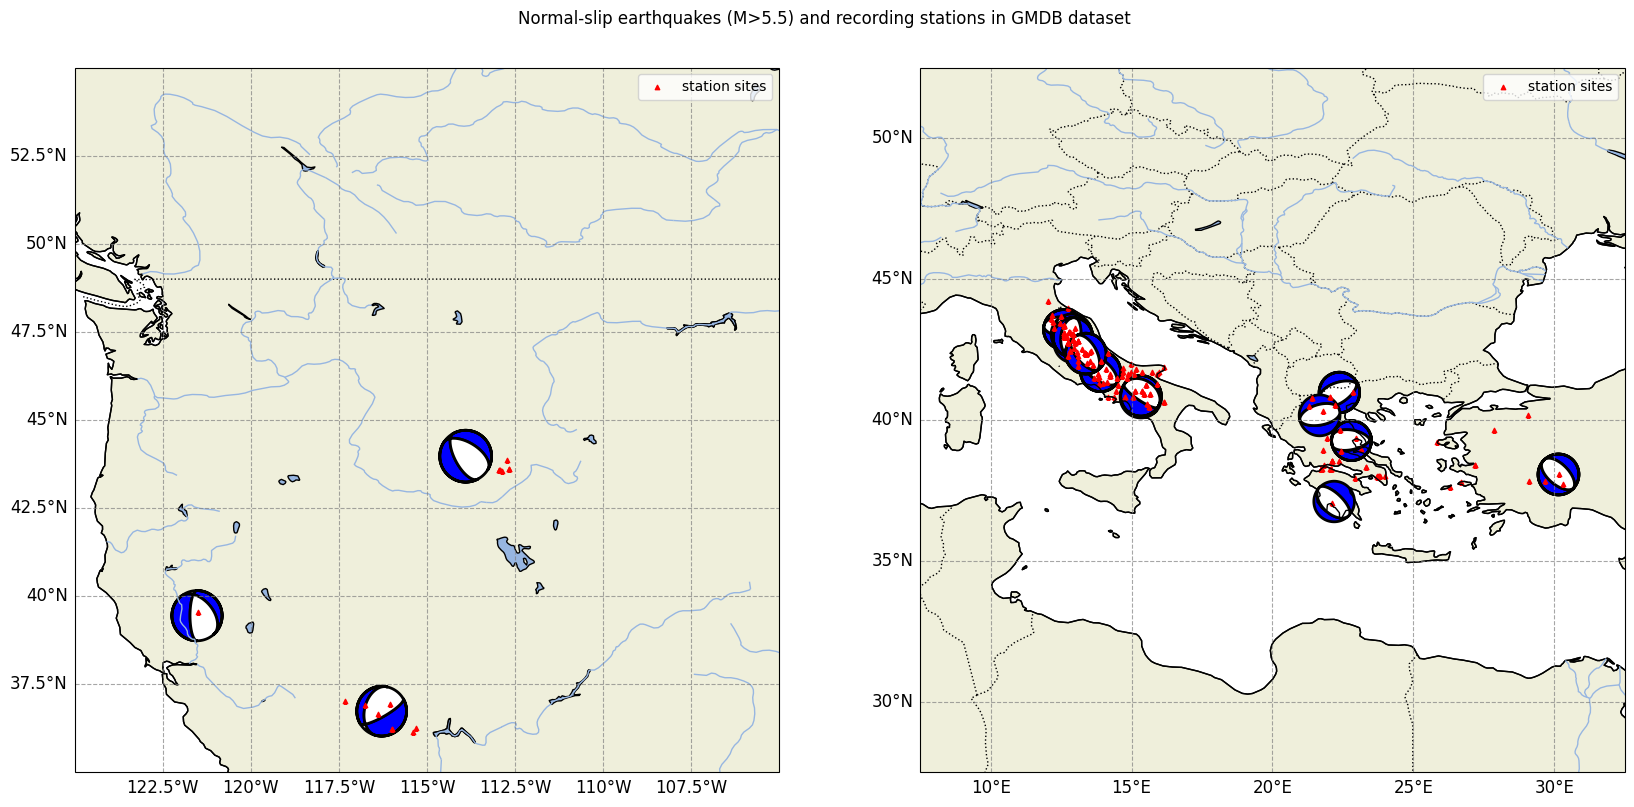

In [158]:
#all rows (with all station data)
site_lats = ns_df['site_latitude']
site_longs = ns_df['site_longitude']

#subset of data with only one row per event
evonly_df = ns_df.drop_duplicates('event_id').reset_index(drop=True)
ev_lons = evonly_df['hypocenter_longitude']
ev_lats = evonly_df['hypocenter_latitude']
ev_mags = evonly_df['magnitude']
ev_dips = evonly_df['dip']
ev_stks = evonly_df['strike']
ev_rakes = evonly_df['rake']

fig, axi = plt.subplots(1,2,figsize=(20,20), subplot_kw={'projection': ccrs.PlateCarree()})

for a in axi:
    a.add_feature(cfeature.COASTLINE)
    a.add_feature(cfeature.BORDERS, linestyle=':')
    a.add_feature(cfeature.LAND, edgecolor='black')
    a.add_feature(cfeature.LAKES, edgecolor='black')
    a.add_feature(cfeature.RIVERS)

    for ii, m in enumerate(ev_mags):
        x, y = ev_lons[ii], ev_lats[ii]
        dsr = [ev_stks[ii],ev_dips[ii],ev_rakes[ii]]
        ball = beach.beach(dsr,xy=(x,y),width=m**0.2)
        a.add_collection(ball).set_zorder(1)

    a.scatter(site_longs, site_lats, marker='^',c='red',label='station sites',s=10)
    # a.scatter(ev_lons, ev_lats, marker='*',color='k',label='earthquake epicenters')
    a.legend()

    gridlines = a.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
    gridlines.top_labels = False  # Disable top labels
    gridlines.right_labels = False  # Disable right labels
    gridlines.xlabel_style = {'size': 12, 'color': 'black'}
    gridlines.ylabel_style = {'size': 12, 'color': 'black'}


US_zoom = zoom_coords(-115,45,20)
EU_zoom = zoom_coords(20,40,25)
axi[0].set_extent(US_zoom, crs=ccrs.PlateCarree())
axi[1].set_extent(EU_zoom, crs=ccrs.PlateCarree())

fig.suptitle(f"Normal-slip earthquakes (M>{mag_max}) and recording stations in GMDB dataset", y=0.70)

plt.show()

In [154]:
rec_counts = ns_df.groupby(['event_name', 'event_id']).size().sort_values(ascending=False)
print(f'Normal faulting events (M>{mag_max}) ordered by number of recordings:\n')
print(rec_counts[:50])

Normal faulting events (M>5.5) ordered by number of recordings:

event_name                           event_id
L'Aquila, Italy                      2532.0      48
Taiwan SMART1(33)                    2407.0      33
Umbria Marche, Italy                 2503.0      12
Irpinia, Italy-01                    2394.0      12
Umbria Marche (aftershock 2), Italy  2512.0      11
Irpinia, Italy-02                    2395.0      10
Umbria Marche (foreshock), Italy     2502.0      10
Borah Peak, ID-01                    2401.0       8
Lazio-Abruzzo, Italy                 2404.0       8
Little Skull MtnNV                   152.0        8
Dinar, Turkey                        2428.0       8
Kozani, Greece-01                    2424.0       7
Umbria-03, Italy                     2494.0       6
Norcia, Italy                        2392.0       3
Northwest China-02                   2438.0       2
Northwest China-03                   2439.0       2
New Zealand-02                       2415.0       2
Griva

## Per-event code starts here

In [17]:
event = ns_df[ns_df['event_id']==2532]

In [100]:
mag = event['magnitude'].iat[0]
dip = event['dip'].iat[0]
mech = 'NS'
zbor = event['fault_width'].iat[0] * np.sin(np.radians(dip))
ztor = event['ztor'].iat[0]

model_event = pygmm.Scenario(
    mag = mag,
    mechanism = mech,
    dip = dip,
    region = 'italy',
    v_s30 = 600,
    depth_tor = ztor,
    depth_bor = zbor, 
    )

xrup = (zbor-ztor) / np.tan(np.radians(dip))

n = 1001

rxs = np.linspace(-150,150,n) # 0 < x: hanging wall only; -x < 0 < x: footwall and hanging wall

xr = np.linspace(0,xrup,n)
zr = np.linspace(ztor,zbor,n)
rrups = np.zeros_like(rxs)
for ii, xx in enumerate(rxs):
    dist = np.sqrt((xr-xx)**2 + zr**2)
    rrups[ii] = np.min(dist)
    # if xx >= 0: rrups[ii] = r 
    # else: rrups[ii] = -r

rjbs = np.where(rxs <= xrup, 0.0, rxs-xrup)
rjbs = np.where(rxs <= 0, -rxs, rjbs)

pgv_med1 = np.zeros_like(rxs)
lpgv_std1 = np.zeros_like(rxs)

for ii in range(pgv_med1.size):
    scen = model_event.copy_with(dist_rup=rrups[ii], dist_x=rxs[ii], dist_jb=rjbs[ii], on_hanging_wall=(rxs[ii]>0))
    model1 = pygmm.AbrahamsonSilvaKamai2014(scen)

    pgv_med1[ii] = model1.pgv
    lpgv_std1[ii] = model1.ln_std_pgv

Text(0.5, 0.93, "Predicted PGVs | L'Aquila, Italy, M x, 48° dip")

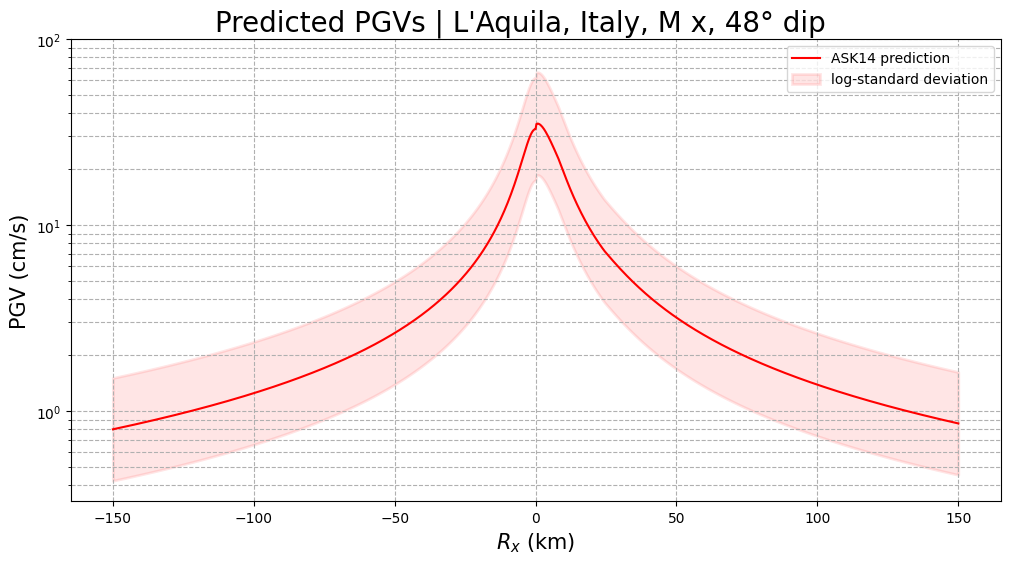

In [101]:
fig, axi = plt.subplots(figsize=[12,6])
axi.plot(rxs,pgv_med1,color='red', label='ASK14 prediction')

axi.set_ylabel('PGV (cm/s)',fontsize=15)
axi.set_xlabel(f'$R_{{x}}$ (km)',fontsize=15)

ly1 = np.exp( np.log(pgv_med1) - lpgv_std1 )
ly2 = np.exp( np.log(pgv_med1) + lpgv_std1 )

axi.fill_between(x=rxs,y1=ly1,y2=ly2,color='r',alpha=0.1,lw=2,label='log-standard deviation')


axi.set_yscale('log')
# axi.set_xlim(-30,40)

axi.grid(which='both',ls='--')

xmin, xmax = axi.get_xlim()
ymin, ymax = axi.get_ylim()
axi.set_ylim(ymin,100)
# axi.axhspan(0,ymax,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
# axi.axhspan(0,ymax,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')

axi.legend()
fig.suptitle(f"Predicted PGVs | {event['event_name'].iat[0]}, M {m}, {int(dip)}° dip",y=0.93, fontsize = 20)

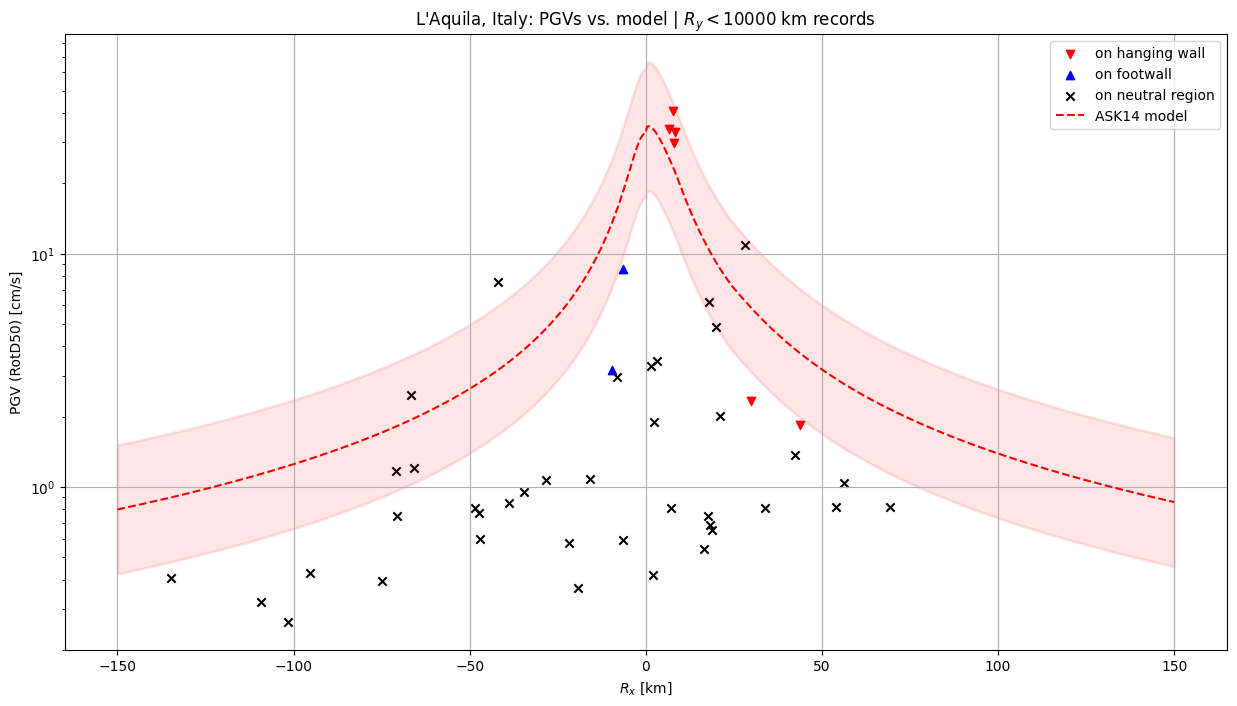

In [102]:
# rymax = event['fault_length'].iat[0] / 2 #maximum ry, to keep records close to the fault
rymax=10000

fig, axi = plt.subplots(1,1,figsize=[15,8])

#laquilasubset = df[df['event_id']==2532][['rx','ry','rrup','hanging_wall','pgv_rotd50','vs30','z1p0_preferred']]
# print(laquilasubset[laquilasubset["hanging_wall"].isin(["f","h"])])

event = event.sort_values(by='rrup', ascending=True)
event = event[event['pgv_rotd50'] > 0]

for i, row in event.iterrows():
    if abs(row['ry']) < rymax:
        c, m, l = get_labels(row['hanging_wall'])
        axi.scatter(row['rx'],row['pgv_rotd50'],c=c,marker=m,label=l)

axi.plot(rxs,pgv_med1,color='red',label='ASK14 model',ls='--')
axi.fill_between(x=rxs,y1=ly1,y2=ly2,color='r',alpha=0.1,lw=2)


axi.set(**{'xlabel': '$R_{x}$ [km]',
            # 'xlim': (-10,10),
            'ylabel': 'PGV (RotD50) [cm/s]',
            'yscale': 'log',
            'title': f"{event['event_name'].iat[0]}: PGVs vs. model | $R_{{y}} < {rymax}$ km records"
        })

axi.grid()

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axi.legend(by_label.values(), by_label.keys())

plt.show()

In [103]:
f_lon = event['hypocenter_longitude'].iat[1]
f_lat = event['hypocenter_latitude'].iat[1]
# f_lon = -116 + 15/60
# f_lat = 35 + 24/60
f_l = event['fault_length'].iat[0]
f_w = event['fault_width'].iat[0]
f_s = event['strike'].iat[0] - 180
f_d = event['dip'].iat[0]
f_r = event['rake'].iat[0]

f_proj= get_fault_proj(f_lon,f_lat,f_l,f_w,f_s,f_d)[1]
print(f'lon: {f_lon}, lat: {f_lat}, length: {f_l}, width: {f_w}, strike: {f_s}, dip: {f_d}')

lon: 13.38, lat: 42.3476, length: 20.0, width: 16.0, strike: -41.0, dip: 48


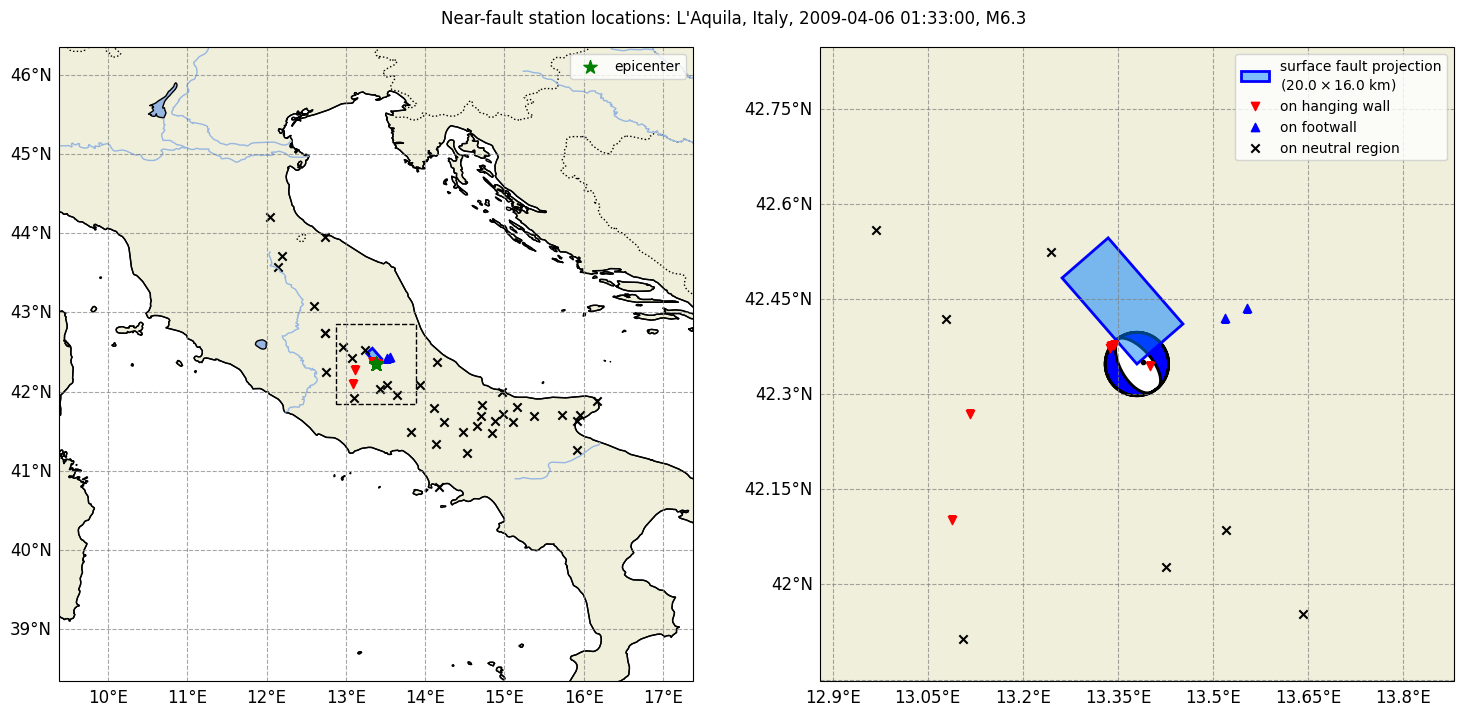

In [105]:
fig, axi = plt.subplots(1,2,figsize=(18,10), subplot_kw={'projection': ccrs.PlateCarree()})

hyp_lon = event['hypocenter_longitude'].iat[1]
hyp_lat = event['hypocenter_latitude'].iat[1]

laq_lon = 15.1
laq_lat = 40.8

#map centered about epicenter
region_zoom = zoom_coords(hyp_lon,hyp_lat,8)
local_zoom = zoom_coords(hyp_lon,hyp_lat,1)
axi[0].set_extent(region_zoom, crs=ccrs.PlateCarree())
axi[0].add_patch(get_inset_poly(*local_zoom))

axi[1].set_extent(local_zoom, crs=ccrs.PlateCarree())
axi[1].scatter(13.39,42.35, marker='.',c='k', zorder=10)
# axi[1].annotate("L'Aquila", 
#             xy=(laq_lon,laq_lat),
#             xytext=(laq_lon,laq_lat-0.1),
#             bbox=dict(boxstyle="round", fc="0.8"),
#             arrowprops=dict(arrowstyle='->'))

for i, ax in enumerate(axi):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    ax.add_feature(cfeature.RIVERS)

    f_proj= get_fault_proj(hyp_lon,hyp_lat,f_l,f_w,f_s,f_d)[1]
    ax.add_patch(f_proj)

    for j, row in event.iterrows():
        if abs(row['ry']) <= rymax:
            c, m, l = get_labels(row['hanging_wall'])
            ax.scatter(row['site_longitude'], row['site_latitude'],c=c,marker=m,label=l)
    if i == 0:
        epi = ax.scatter(event['hypocenter_longitude'], event['hypocenter_latitude'], marker='*',color='g',s=100, zorder=2)
        ax.legend(handles=[epi], labels=["epicenter"])
    elif i == 1:
        ax.add_collection(beach.beach([f_s,f_d,f_r],xy=(f_lon,f_lat),width=0.1)).set_zorder(0)
        handles, labels = fig.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

    gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
    gridlines.top_labels = False  # Disable top labels
    gridlines.right_labels = False  # Disable right labels
    gridlines.xlabel_style = {'size': 12, 'color': 'black'}
    gridlines.ylabel_style = {'size': 12, 'color': 'black'}



# ax.add_collection(beach.beach([f_s,f_d,f_r],xy=(f_lon,f_lat),width=0.08))

fig.suptitle(f"Near-fault station locations: {event['event_name'].iat[0]}, {event['datetime'].iat[0]}, M{mag}",y=0.85)

plt.show()

In [106]:
pgvs_per_sta = []
stds_per_sta = []

for i, row in event.iterrows():
    vs30 = row['vs30']
    rrup = row['rrup']
    rx = row['rx']
    rjb = row['rjb']

    hw = row['hanging_wall'] == 'h'

    scen = model_event.copy_with(dist_rup=rrup, dist_x=rx, dist_jb=rjb, on_hanging_wall=hw, v_s30=vs30)
    model1 = pygmm.AbrahamsonSilvaKamai2014(scen)

    pgvs_per_sta.append(model1.pgv)
    stds_per_sta.append(model1.ln_std_pgv)

residuals = event['pgv_rotd50'] - pgvs_per_sta
zscore = (np.log(event['pgv_rotd50']) - np.log(pgvs_per_sta)) / stds_per_sta

/var/folders/sn/vc1jwppj6ksd93y_fp9nbjvc0000gp/T/ipykernel_50029/3838676491.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [ax.legend() for ax in axi]


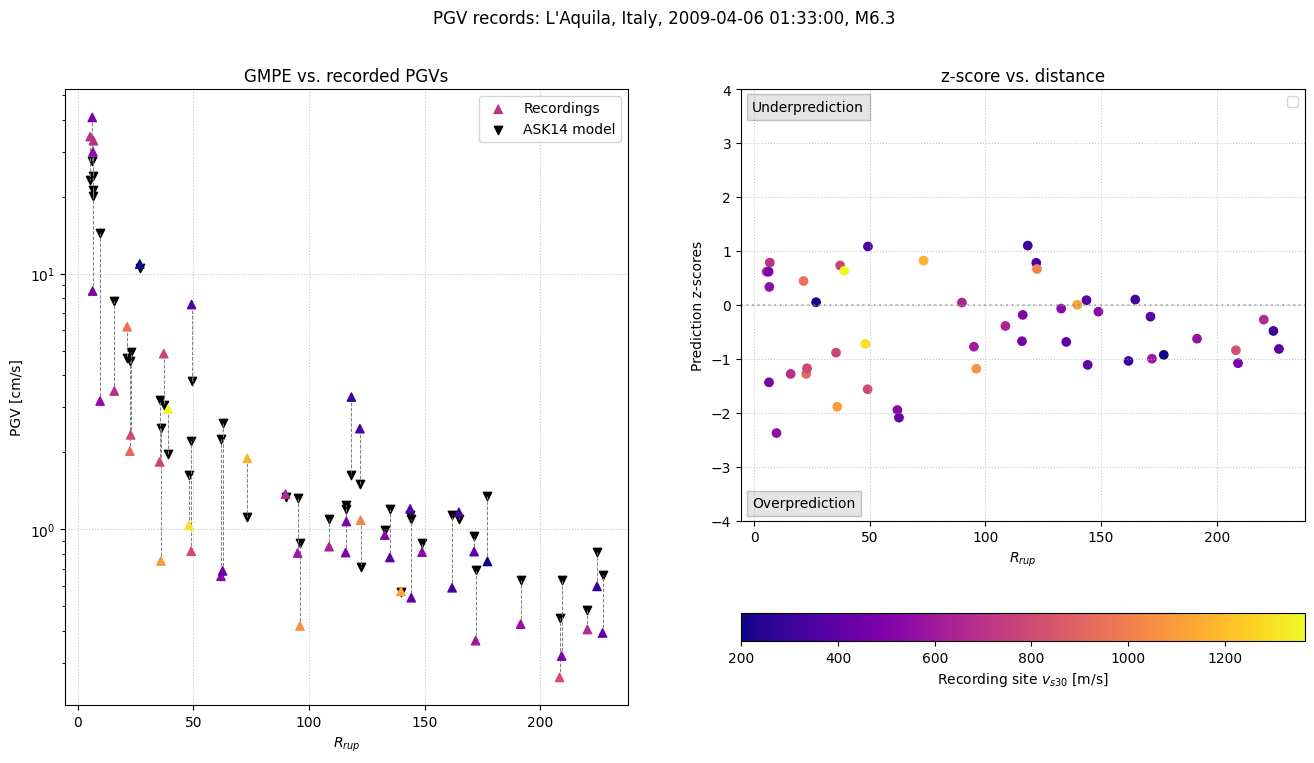

In [107]:
fig, axi = plt.subplots(1,2,figsize=[16,8])

x = event['rrup']
y1 = event['pgv_rotd50']
y2 = pgvs_per_sta

for xx, yy1, yy2 in zip(x,y1,y2):
    axi[0].plot([xx,xx],[yy1,yy2],c='gray',ls='--',lw=0.7)

axi[0].scatter(x,y1,marker='^',c=event['vs30'],cmap='plasma',label='Recordings',zorder=10)
axi[0].scatter(x,y2,marker='v',c='k',label='ASK14 model')

# rec = axi[1].scatter(x,residuals,marker='o',c=event['vs30'],cmap='plasma')
rec = axi[1].scatter(x,zscore,marker='o',c=event['vs30'],cmap='plasma')
axi[1].axhline(y=0,ls=':',c='gray',alpha=0.5)
axi[1].text(0.02,0.95,s='Underprediction',bbox=dict(facecolor='gray', alpha=0.2),transform=axi[1].transAxes)
axi[1].text(0.02,0.03,s='Overprediction',bbox=dict(facecolor='gray', alpha=0.2),transform=axi[1].transAxes)


axi[0].set(**{
    'yscale': 'log',
    'ylabel': 'PGV [cm/s]',
    'xlabel': '$R_{rup}$',
    'title': 'GMPE vs. recorded PGVs'
})

axi[1].set(**{
    'title': 'z-score vs. distance',
    'yscale': 'linear',
    'ylim': [-4,4],
    'ylabel': 'Prediction z-scores',
    'xlabel': '$R_{rup}$',
})

[ax.legend() for ax in axi]
[ax.grid(ls=':',alpha=0.7,zorder=-10) for ax in axi]

fig.colorbar(rec,label="Recording site $v_{s30}$ [m/s]",location='bottom')
# fig.suptitle("2009 L'Aquila earthquake PGVs")
fig.suptitle(f"PGV records: {event['event_name'].iat[0]}, {event['datetime'].iat[0]}, M{mag}")

plt.show()

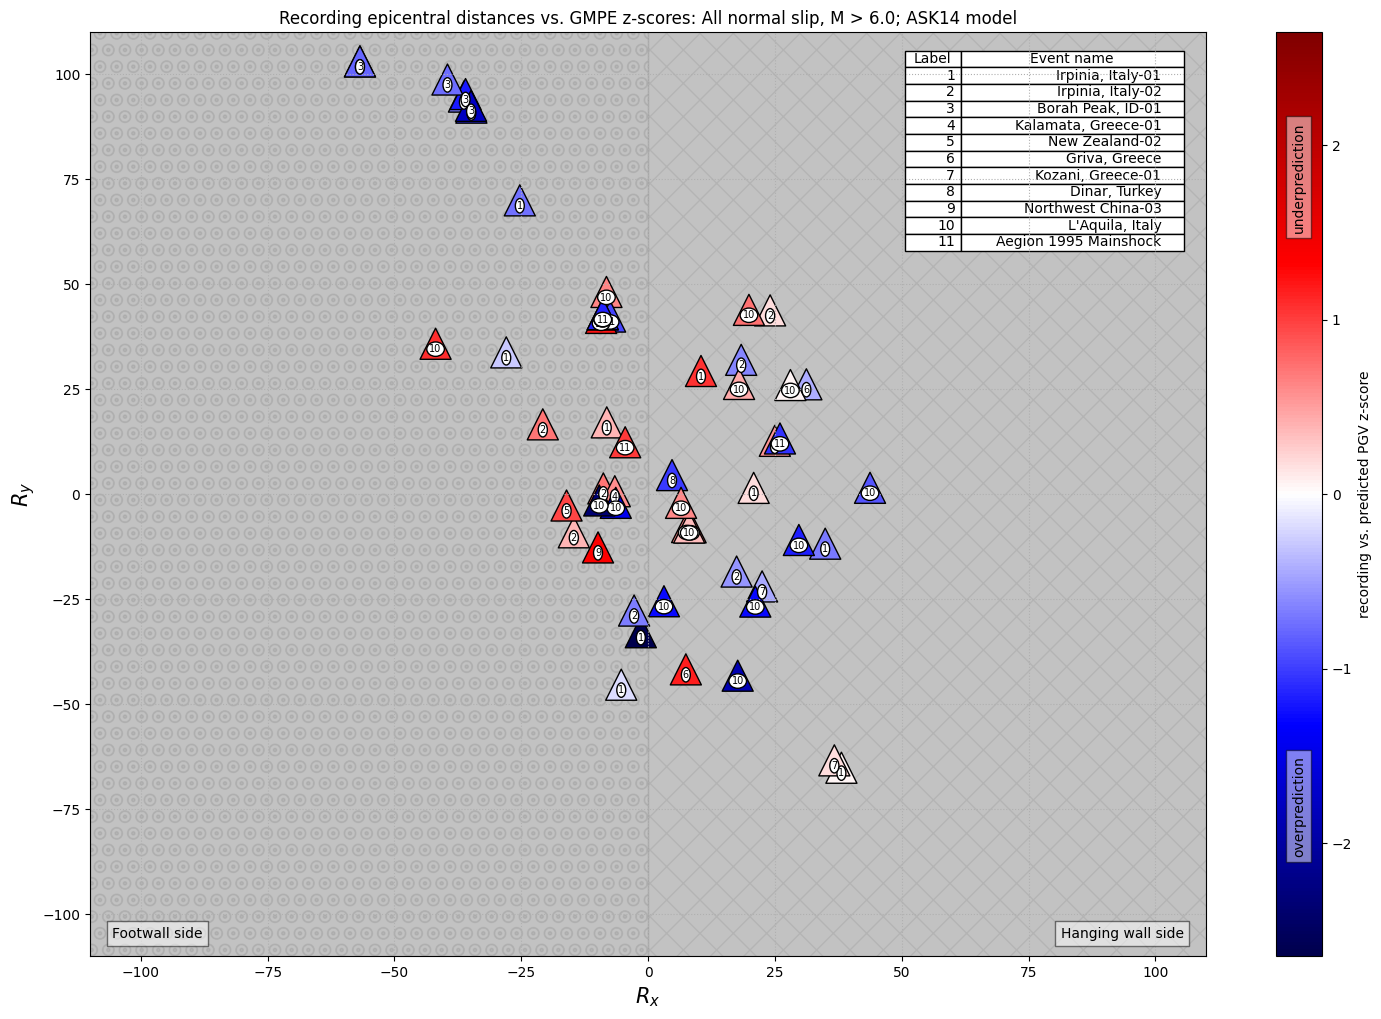

In [129]:
fig, ax = plt.subplots(1,1,figsize=[18,12])

ns_big = ns_df[ns_df['pgv_rotd50'] > 0]

fault_param = 3. # minimum number of fault heights/widths of distance to consider a station "near-fault"

zscores = []
recs = []
rxs = []
rys = []
evs = []
markers = []
labels = []

nameind = 0
evnames = {}


for i, row in ns_big.iterrows():
    ry = abs(row['ry'])
    rx = abs(row['rx'])
    rymax = fault_param * row['fault_length']
    rxmax = fault_param * row['fault_width']

    if ry < rymax and rx < rxmax:
        hw = row['hanging_wall'] == 'h'

        model_event = pygmm.Scenario(mag = row['magnitude'],
                                     mechanism = 'NS',
                                     dip = row['dip'],
                                     region = 'italy',
                                     v_s30 = row['vs30'],
                                     depth_tor = row['ztor'],
                                     depth_bor = event['fault_width'] * np.sin(np.radians(row['dip'])), 
                                    )
        
        scen = model_event.copy_with(dist_rup=row['rrup'], dist_x=row['rx'], dist_jb=row['rjb'], on_hanging_wall=hw, v_s30=row['vs30'])
        ask = pygmm.AbrahamsonSilvaKamai2014(scen)
        ask_pgv, ask_log_std = ask.pgv, ask.ln_std_pgv

        z = (np.log(row['pgv_rotd50']) - np.log(ask_pgv)) / ask_log_std

        zscores.append(z)
        recs.append(row['pgv_rotd50'])
        rxs.append(row['rx'])
        rys.append(row['ry'])
        evs.append(row['event_name'])

        c, m, l = get_labels(row['hanging_wall'])
        markers.append(m)
        
        #extract event names to dictioinary (needed for handling multiple recordings with the same event_name) and use as labels
        evname = row['event_name']
        if evname not in evnames.keys():
            nameind += 1
        evnames.setdefault(evname,nameind) #create new event name index

        labels.append(nameind)

points = ax.scatter(rxs,rys,c=zscores,s=500,cmap='seismic',norm=colors.CenteredNorm(),marker='^',edgecolors='k')

for i, l in enumerate(labels):
    ax.text(rxs[i],rys[i]-2,l,fontsize=7,c='k',ha='center',bbox=dict(
        facecolor='white',
        boxstyle='ellipse,pad=0.01'
    ))

xlim, ylim = 110, 110
ax.set(**{
    'facecolor': 'lightgray',
    'ylim': [-ylim,ylim],
    'xlim': [-xlim,xlim]
})
ax.set_xlabel('$R_x$', fontsize=15)
ax.set_ylabel('$R_y$', fontsize=15)

ax.text(0.02,0.02,s='Footwall side',bbox=dict(facecolor='w', alpha=0.5),transform=ax.transAxes)
ax.text(0.98,0.02,s='Hanging wall side',ha='right',bbox=dict(facecolor='w', alpha=0.5),transform=ax.transAxes)
ax.axhspan(-ylim,ylim,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0)
ax.axhspan(-ylim,ylim,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0)

ax.grid(ls=':')

txt = [[v, k] for k, v in evnames.items()]
the_table = plt.table(cellText=txt,
                      loc=1,
                      colLabels=['Label','Event name'],
                      cellLoc='right',
                      colWidths=[0.05,0.2],
                      )

cbar = fig.colorbar(points,label="recording vs. predicted PGV z-score")
cbar.ax.get_yaxis()
cbar.ax.text(.5, -1.5, "overprediction", bbox=dict(facecolor='w', alpha=0.5), rotation=90, ha='center', va='top')
cbar.ax.text(.5, 1.5, "underprediction", bbox=dict(facecolor='w', alpha=0.5), rotation=90, ha='center', va='bottom')

ax.set_title(f'Recording epicentral distances vs. GMPE z-scores: All normal slip, M > {mag_max}; ASK14 model')
plt.show()